<a href="https://colab.research.google.com/github/ohapearse/ESBL_acquisition_Chatinkha/blob/master/msm_kleb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSM analysis of Chatinkha Res using PyMC3

This details the progress I have made so far in coding an MSM in PyMC3. 

## Summary of the model as it stands

We model a markov process in continuous time in which a neonate can be in state $S(t)$ at time $t$. The construction of the model is similar to that used in the MSM package and Lewis (in press). For the purposes of our model each neonate can be in one of two states, either uncolonised $(u)$ or colonised $(c)$.

$$U \overset{\lambda}{\rightarrow} C$$

We model neonates from birth and assume that at birth $(t = 0)$ a neonate is uncolonised $(S(t) = u)$. Neonates are followed up until discharge or day 7 of admission, with up to 3 rectal samples taken on day 0, day 3 and day 7. Once a neonate becomes colonised we no longer include their data in the model, as on the timescales of our study they are unlikely to become uncolonised. As such the only transition that is allowed is from $u$ to $c$ (illustrated above). We are interested in estimating the probability of this transition, $\lambda$, as well as the probability and predictors of the transition. This is similar to a standard survival model, except for the assumption that the exact time of colonisation is known as our data is panel data with arbitrary observation times.

Given an individual $i$ starts out uncolonised at time $t$, then the probability they will have been infected by time $t=T$ is

$$Pr(i \in C{T} | i \in {U}(t)) = p_{uc}(1 - p_{uc})^{T-t-1}$$

Conversely, if $i$ is *not* colonised by time $t=T$ then

$$Pr(i \in U{T} | i \in {U}(t)) = (1 - p_{uc})^{T-t}$$

The likelihood is then the product of terms over $i$ for each colonisation or survival event:

$$L(Y | p) = \prod_{i=1}{n} p_{uc}^{1(U_i {\rightarrow} C_i)}(1 - p_{uc})^{t_i}$$

**Need to add section on estimation of covariates**


## What I have done so far

This is the updated model, edited by Chris, which includes an updated likelihood function which works effectively. We have abandoned the Q matrix as it is unecessary. 


In [ ]:
#Importing the libraries
import pandas as pd
import numpy as np
import numpy.ma as ma
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt
from theano import *
import theano.tensor as tt
import theano.tensor.slinalg as ttl
#theano.config.compute_test_value = 'raise'
#theano.config.compute_test_value = 'off'

#loading the data
msm_kleb = pd.read_csv(r"msm_data_simple.csv")
#loading the data with covariates
msm_cov = pd.read_csv(r"msm_data_cov.csv")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


A little bit of work on the data. Which covariates have missing values? Maternal antibiotics has 5 missing values and maternal hiv has 10 missing values. 

In [ ]:
msm_cov
msm_cov.isna().sum()

Unnamed: 0     0
Neo            0
interval       0
tstart         0
tstop          0
init_state     0
end_state      0
matabxall      5
preterm        0
intabx         0
neoabx         0
outborn        0
sex            0
dlivmod        0
mathiv        10
lbw            0
o2             0
notbreast      0
dtype: int64

There are 2 covariates missing that need to be added (maternal cont and onward). These are time-varying and will need to be added. 

Now will also fill in all the NaNs - this is just temporary to get the code to work, once it is working, will deal with the NaNs properly - by using PyMC3 to impute them. 

In [ ]:
msm_cov2 = msm_cov.fillna(0)

In [ ]:
#this function generates the log likelihood for the data when it is given a probability of transition
def trans_likelihood(state1, state2, tstart, tstop, covariates,
                     lambda0, 
                     beta1,
                     beta2,
                     beta3,
                     beta4,
                     beta5,
                     beta6,
                     beta7,
                     beta8,
                     beta9,
                     beta10,
                     beta11):
    
    #combining the coefficients from the covariates to come up with an overall value for 
    eta = (lambda0
           + beta1*covariates['matabxall']
           + beta2*covariates['preterm']
           + beta3*covariates['intabx']
           + beta4*covariates['neoabx']
           + beta5*covariates['outborn']
           + beta6*covariates['sex']
           + beta7*covariates['dlivmod']
           + beta8*covariates['mathiv']
           + beta9*covariates['lbw']
           + beta10*covariates['o2']
           + beta11*covariates['notbreast'])
    #NEED TO FIGURE OUT HOW TO ACCOUNT FOR TIME
    #ALSO NEED TO CHECK WHETHER THE NEW LIKELIHOOD ACCOUNTS FOR UNCERTAINTY AROUND WHETHER
    #creating a value for p from the covariates
    p = tt.exp(eta)/(1+tt.exp(eta))
    #probability of not being colonised is 1 - probability of being colonised
    notp = 1 - p  # Pr(survive a timestep)
    #vector with a 1 when babies are colonised but a zero when they are not
    is_colonised = tt.where(state2 == 2, 1.0, 0.0)
    #this determines the length of time for which babies are not colonised
    num_steps_survives = tstop - tstart - is_colonised
    #log likelihood for one baby
    log_lik = num_steps_survives * tt.log(notp) + is_colonised * tt.log(p)
    #defining the likelihood for all babies
    totL = tt.sum(log_lik)
    return totL

In [ ]:
covariates = msm_cov2[['matabxall', 
                        'preterm',
                        'intabx',
                        'neoabx',
                        'outborn',
                        'sex',
                        'dlivmod',
                        'mathiv',
                        'lbw',
                        'o2',
                        'notbreast']]

#trans_likelihood(state1=msm_cov['init_state'],
#                state2=msm_cov['end_state'],
#                tstart=msm_cov['tstart'],
#                tstop=msm_cov['tstop'],
#               covariates=covariates,
#                lambda0=1,
#                beta1=1,
#                beta2=1,
#                beta3=1,
#                beta4=1,
#                beta5=1,
#                beta6=1,
#                beta7=1,
#                beta8=1,
#                beta9=1,
#                beta10=1,
#               beta11=2)



Next we will run the model itself. With the updated likelihood function it works well

C:\Users\ohape\AppData\Local\Temp/ipykernel_8124/4013372354.py:42: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  samples = pm.sample(3000, tune=1000,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [notbreast, o2, lbw, mathiv, dlivmod, sex, outborn, neoabx, intabx, preterm, matabxall, alpha0]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 48 seconds.
C:\Users\ohape\AppData\Local\Temp/ipykernel_8124/4013372354.py:75: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(samples)


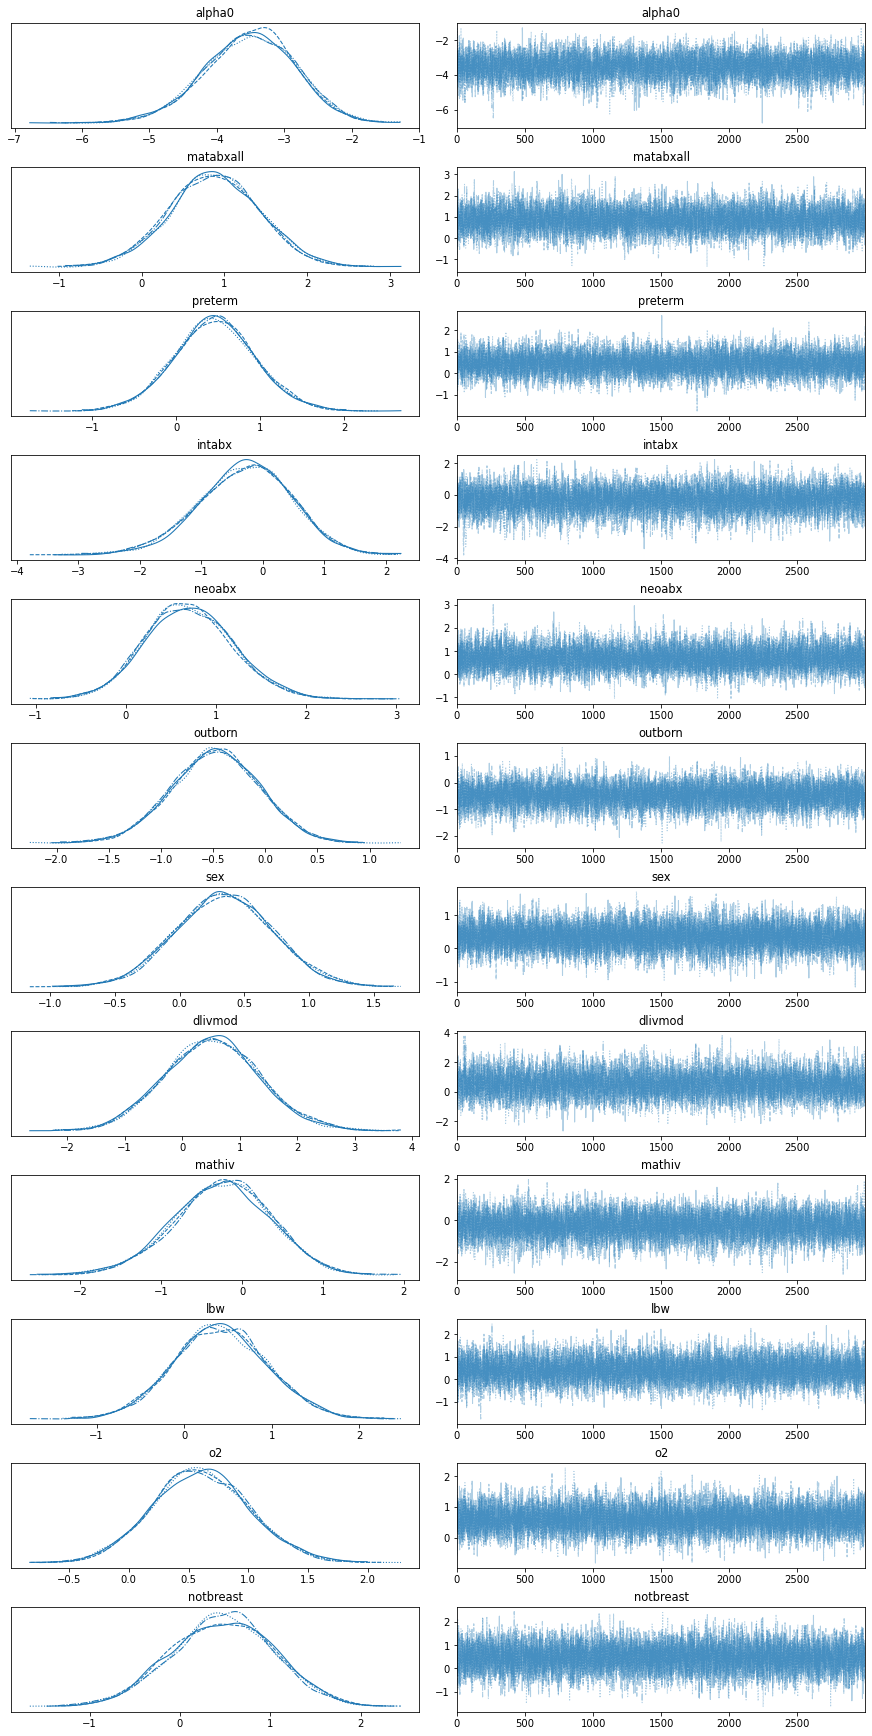

In [ ]:
#this is the model itself
if __name__ ==  '__main__':
    def run_mcmc(state1, state2, tstart, tstop, covariates):
        with pm.Model() as model:
    
            #setting priors
            #prior for alpha
            lambda0 = pm.Normal('alpha0', mu=0, sd=1000)
            #priors for betas
            beta1 = pm.Normal('matabxall', mu=0, sd=1000)
            beta2 = pm.Normal('preterm', mu=0, sd=1000)
            beta3 = pm.Normal('intabx', mu=0, sd=1000)
            beta4 = pm.Normal('neoabx', mu=0, sd=1000)
            beta5 = pm.Normal('outborn', mu=0, sd=1000)
            beta6 = pm.Normal('sex', mu=0, sd=1000)
            beta7 = pm.Normal('dlivmod', mu=0, sd=1000)
            beta8 = pm.Normal('mathiv', mu=0, sd=1000)
            beta9 = pm.Normal('lbw', mu=0, sd=1000)
            beta10 = pm.Normal('o2', mu=0, sd=1000)  
            beta11 = pm.Normal('notbreast', mu=0, sd=1000)
    
            #now using pm.Potential to use the custom log-likelihood function to calculate lambda0
            llh = pm.Potential('llh', trans_likelihood(state1 = state1, 
                                                       state2 = state2, 
                                                       tstart = tstart, 
                                                       tstop = tstop, 
                                                       covariates = covariates,
                                                       lambda0 = lambda0,
                                                       beta1 = beta1,
                                                       beta2 = beta2,
                                                       beta3 = beta3,
                                                       beta4 = beta4,
                                                       beta5 = beta5,
                                                       beta6 = beta6,
                                                       beta7 = beta7,
                                                       beta8 = beta8,
                                                       beta9 = beta9,
                                                       beta10 = beta10,
                                                       beta11 = beta11
                                                      ))
        
            samples = pm.sample(3000, tune=1000, 
                                target_accept = 0.9
                                )
        
            return samples, model
        
        
            covariates = msm_cov2[['matabxall', 
                        'preterm',
                        'intabx',
                        'neoabx',
                        'outborn',
                        'sex',
                        'dlivmod',
                        'mathiv',
                        'lbw',
                        'o2',
                        'notbreast']]
    
    #centering the covariates
    #covariates = covariates - np.average(covariates, 
    #                                     weights= td_surv['tstop'] - td_surv['tstart'], 
    #                                     axis=0)
    
  #running the model
    samples, model = run_mcmc(state1 = msm_cov2['init_state'].to_numpy(), 
                              state2 = msm_cov2['end_state'].to_numpy(), 
                              tstart = msm_cov2['tstart'].to_numpy(), 
                              tstop = msm_cov2['tstop'].to_numpy(),
                              covariates = covariates
                              )
#plotting traceplots
    with model:
        pm.traceplot(samples)

This seems to work relatively well. Now need to deal with the missing data properly by creating a masked array.

In [ ]:
covariates_imp = msm_cov[['matabxall', 
                        'preterm',
                        'intabx',
                        'neoabx',
                        'outborn',
                        'sex',
                        'dlivmod',
                        'mathiv',
                        'lbw',
                        'o2',
                        'notbreast']]

covariates_imp = np.ma.masked_invalid(covariates_imp)
covariates_imp

masked_array(
  data=[[1.0, 0.0, 1.0, ..., 0.0, 1.0, 0.0],
        [1.0, 0.0, 1.0, ..., 0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0, ..., 0.0, 1.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 1.0, 0.0],
        [--, 0.0, 0.0, ..., 0.0, 1.0, 0.0],
        [--, 0.0, 0.0, ..., 0.0, 1.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False]],
  fill_value=1e+20)

In [ ]:
#reshaping the likelihood function so that it will accept the masked array
def trans_likelihood_mask(state1, state2, tstart, tstop, covariates,
                     lambda0, 
                     beta1,
                     beta2,
                     beta3,
                     beta4,
                     beta5,
                     beta6,
                     beta7,
                     beta8,
                     beta9,
                     beta10,
                     beta11):
    
    #combining the coefficients from the covariates to come up with an overall value for 
    eta = (lambda0
           + beta1*covariates[:,0]
           + beta2*covariates[:,1]
           + beta3*covariates[:,2]
           + beta4*covariates[:,3]
           + beta5*covariates[:,4]
           + beta6*covariates[:,5]
           + beta7*covariates[:,6]
           + beta8*covariates[:,7]
           + beta9*covariates[:,8]
           + beta10*covariates[:,9]
           + beta11*covariates[:,10])
    #NEED TO FIGURE OUT HOW TO ACCOUNT FOR TIME
    #ALSO NEED TO CHECK WHETHER THE NEW LIKELIHOOD ACCOUNTS FOR UNCERTAINTY AROUND WHETHER
    #creating a value for p from the covariates
    p = tt.exp(eta)/(1+tt.exp(eta))
    #probability of not being colonised is 1 - probability of being colonised
    notp = 1 - p  # Pr(survive a timestep)
    #vector with a 1 when babies are colonised but a zero when they are not
    is_colonised = tt.where(state2 == 2, 1.0, 0.0)
    #this determines the length of time for which babies are not colonised
    num_steps_survives = tstop - tstart - is_colonised
    #log likelihood for one baby
    log_lik = num_steps_survives * tt.log(notp) + is_colonised * tt.log(p)
    #defining the likelihood for all babies
    totL = tt.sum(log_lik)
    return totL

C:\Users\ohape\AppData\Local\Temp/ipykernel_8124/3646916070.py:42: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  samples = pm.sample(3000, tune=1000,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [notbreast, o2, lbw, mathiv, dlivmod, sex, outborn, neoabx, intabx, preterm, matabxall, alpha0]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 49 seconds.
C:\Users\ohape\AppData\Local\Temp/ipykernel_8124/3646916070.py:65: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(samples)


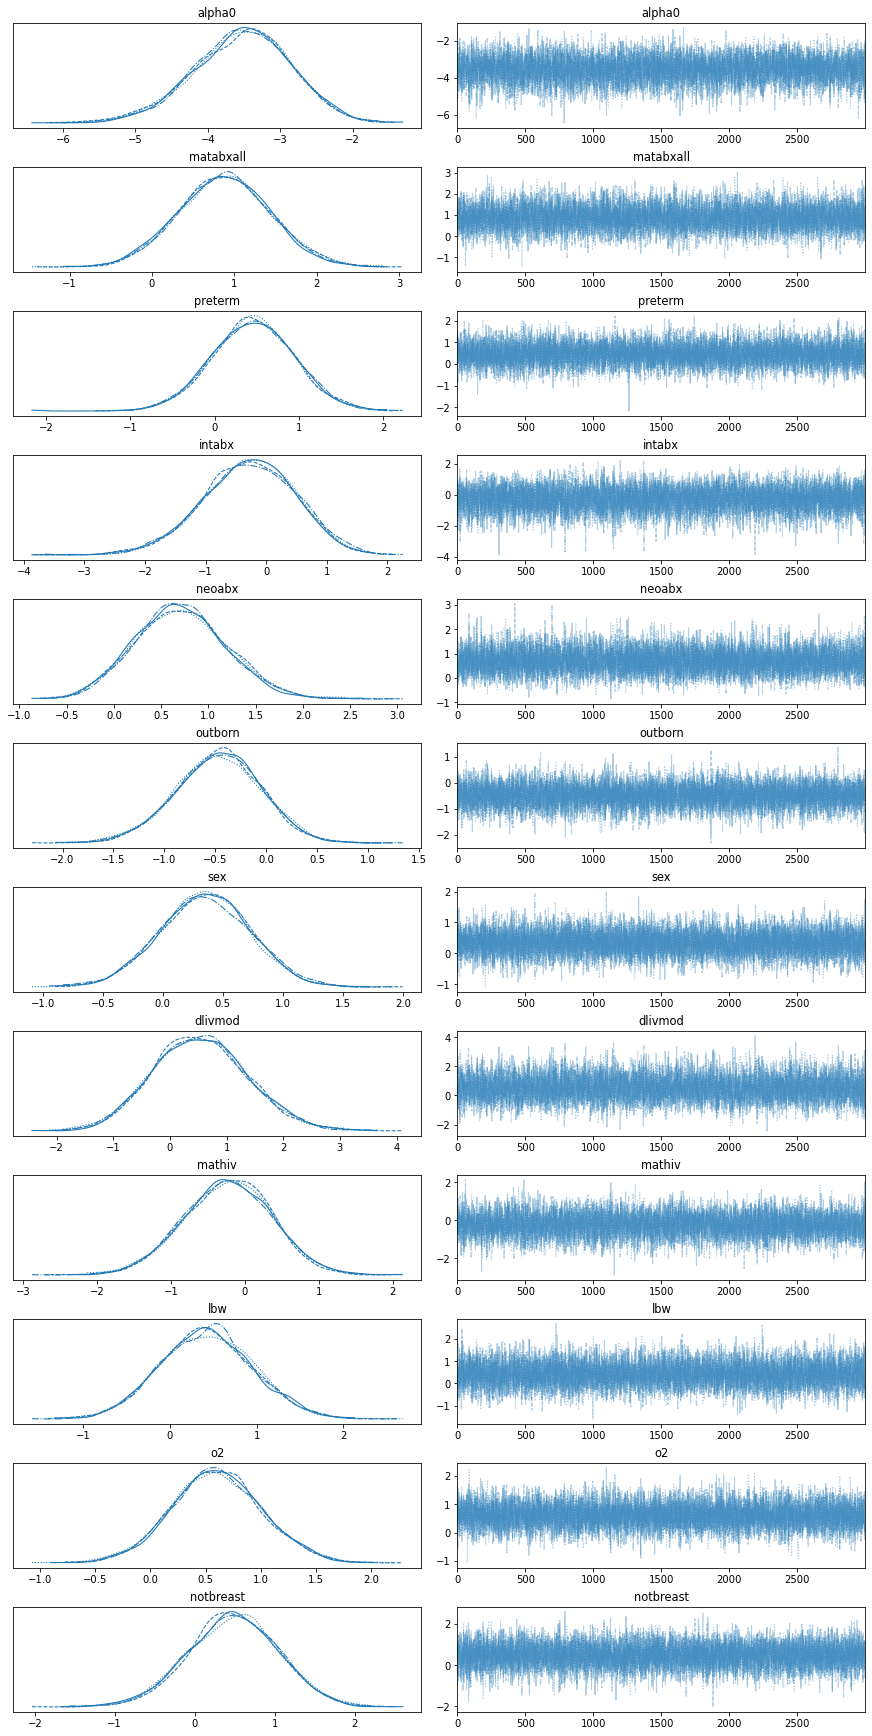

In [ ]:
#this is the model itself running the imputed data
if __name__ ==  '__main__':
    def run_mcmc(state1, state2, tstart, tstop, covariates):
        with pm.Model() as model:
    
            #setting priors
            #prior for alpha
            lambda0 = pm.Normal('alpha0', mu=0, sd=1000)
            #priors for betas
            beta1 = pm.Normal('matabxall', mu=0, sd=1000)
            beta2 = pm.Normal('preterm', mu=0, sd=1000)
            beta3 = pm.Normal('intabx', mu=0, sd=1000)
            beta4 = pm.Normal('neoabx', mu=0, sd=1000)
            beta5 = pm.Normal('outborn', mu=0, sd=1000)
            beta6 = pm.Normal('sex', mu=0, sd=1000)
            beta7 = pm.Normal('dlivmod', mu=0, sd=1000)
            beta8 = pm.Normal('mathiv', mu=0, sd=1000)
            beta9 = pm.Normal('lbw', mu=0, sd=1000)
            beta10 = pm.Normal('o2', mu=0, sd=1000)  
            beta11 = pm.Normal('notbreast', mu=0, sd=1000)
    
            #now using pm.Potential to use the custom log-likelihood function to calculate lambda0
            llh = pm.Potential('llh', trans_likelihood(state1 = state1, 
                                                       state2 = state2, 
                                                       tstart = tstart, 
                                                       tstop = tstop, 
                                                       covariates = covariates,
                                                       lambda0 = lambda0,
                                                       beta1 = beta1,
                                                       beta2 = beta2,
                                                       beta3 = beta3,
                                                       beta4 = beta4,
                                                       beta5 = beta5,
                                                       beta6 = beta6,
                                                       beta7 = beta7,
                                                       beta8 = beta8,
                                                       beta9 = beta9,
                                                       beta10 = beta10,
                                                       beta11 = beta11
                                                      ))
        
            samples = pm.sample(3000, tune=1000, 
                                target_accept = 0.9
                                )
        
            return samples, model
        
        
            covariates = covariates_imp
    
    #centering the covariates
    #covariates = covariates - np.average(covariates, 
    #                                     weights= td_surv['tstop'] - td_surv['tstart'], 
    #                                     axis=0)
    
  #running the model
    samples, model = run_mcmc(state1 = msm_cov2['init_state'].to_numpy(), 
                              state2 = msm_cov2['end_state'].to_numpy(), 
                              tstart = msm_cov2['tstart'].to_numpy(), 
                              tstop = msm_cov2['tstop'].to_numpy(),
                              covariates = covariates
                              )
#plotting traceplots
    with model:
        pm.traceplot(samples)

## Questions and next steps

- I need to figure out how to add the time dependent variables. I am a little stuck in how to add these to the likelihood function without complicating it a lot. The variables that need to be added are maternal colonisation and being on the ward. It may be that we have a complex way of accounting for the uncertainty around the mothers time of colonisation, and I am not sure whether being on the ward is a useful variable or not (it is dependent on the age of the baby so may be quite biased).
- Does the current model still account for the uncertainty in timing of the change from u to c.
- Need to figure out how to model the uncertainty around the mothers time of colonisation. 
